In [1]:
import numpy as np
import pandas as pd
import matplotlib as mp
import statsmodels.api as sm

from statsmodels.sandbox.regression.gmm import IV2SLS 
# There is a package named IV2SLS in Python. Do not use this package! The exogenous explanatory variables must
# be entered as instruments. So it gives wrong answers
from statsmodels.sandbox.regression.gmm import GMM

# Part 1

In [2]:
input_table = pd.read_csv('https://raw.githubusercontent.com/EthanRosehart/PM_Assignments/refs/heads/main/midterm_partone.csv')
input_table.head()

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446


In [3]:
model_iv = sm.OLS(input_table["Inventory Turnover"],input_table[["Constant","Current Ratio","Quick Ratio",\
                                                                 "Debt Asset Ratio"]]).fit()
endog_predict = model_iv.predict(input_table[["Constant","Current Ratio","Quick Ratio","Debt Asset Ratio"]])
input_table["Endogenous Param"] = endog_predict

In [4]:
model_2sls = sm.OLS(input_table["Stock Change"], input_table[["Constant","Endogenous Param",\
                                                              "Operating Profit","Interaction Effect",\
                                                             ]]).fit()
model_2sls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Stock Change   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     8.530
Date:                Tue, 05 Nov 2024   Prob (F-statistic):           1.27e-05
Time:                        13:36:04   Log-Likelihood:                -1186.5
No. Observations:                1696   AIC:                             2381.
Df Residuals:                    1692   BIC:                             2403.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Constant              -0.0176      0.020     -0.896      0.370      -0.056       0.021
Endogenous Param       0.0011      0.001      1.827      0.068   -7.76e-05       0.002
Operating Profit      -0.1201      0.028     -4.319      0.000      -0.175      -0.066
Interaction Effect     0.0014      0.000      3.621      0.000       0.001       0.002
==============================================================================
Omnibus:                      368.832   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3433.920
Skew:                           0.742   Prob(JB):                         0.00
Kurtosis:                       9.811   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
y_vals  = np.array(input_table["Stock Change"])
x_vals  = np.array(input_table[["Inventory Turnover","Operating Profit","Interaction Effect"]])
iv_vals = np.array(input_table[["Current Ratio","Quick Ratio","Debt Asset Ratio"]])

class gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3 = params
        endog = self.endog
        exog = self.exog
        inst = self.instrument   

        error0 = endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]
        error1 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,1]
        error2 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,2]
        error3 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,0] 
        error4 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,1] 
        error5 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,2] 

        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g


beta0 = np.array([0.1, 0.1, 0.1, 0.1])
res = gmm(endog = y_vals, exog = x_vals, instrument = iv_vals, k_moms=6, k_params=4).fit(beta0)

res.summary()

Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000373
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 gmm Results                                  
==============================================================================
Dep. Variable:                      y   Hansen J:                       0.6317
Model:                            gmm   Prob (Hansen J):                 0.729
Method:                           GMM                                         
Date:                Tue, 05 Nov 2024                                         
Time:                        15:01:55                                         
No. Observations:                1696                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0           -0.0200      0.021     -0.964      0.335      -0.061       0.021
p 1            0.0011      0.001      1.843      0.065   -6.89e-05       0.002
p 2           -0.1071      0.032     -3.370      0.001      -0.169      -0.045
p 3            0.0011      0.000      2.760      0.006       0.000       0.002
==============================================================================
"""

In [12]:
# Extract estimated parameters from the fitted model
p0, p1, p2, p3 = res.params

# Calculate residuals using the fitted parameters
residuals = y_vals - (p0 + p1 * x_vals[:, 0] + p2 * x_vals[:, 1] + p3 * x_vals[:, 2])

# Display the first few residuals for verification
print("Residuals:", residuals[:10])


Residuals: [ 0.90058799  0.01726681  0.07630791 -0.82613873 -0.10121039  0.27399375
 -0.51346708  0.03122259  0.1936216  -0.25393992]


In [13]:
# Calculate delta as the average bias term: delta = (Z.T * residuals) / (Z.T * Z)
z_vals = iv_vals  # instrumental variables matrix
delta = np.dot(z_vals.T, residuals) / np.dot(z_vals.T, z_vals).diagonal()

# Display the calculated delta values for each instrument
print("Calculated delta values:", delta)

Calculated delta values: [-0.00187604 -0.00412188 -0.00082137]


In [14]:
# Define a new GMM class that incorporates delta values into the moment conditions
class gmm_with_delta(GMM):
    def momcond(self, params):
        p0, p1, p2, p3 = params
        endog = self.endog
        exog = self.exog
        inst = self.instrument

        # Adjust moment conditions with the calculated delta values for each instrument
        error0 = endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2]
        error1 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2]) * exog[:, 1]
        error2 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2]) * exog[:, 2]
        error3 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2] - delta[0]) * inst[:, 0]
        error4 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2] - delta[1]) * inst[:, 1]
        error5 = (endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2] - delta[2]) * inst[:, 2]

        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g

# Run the GMM model with the delta values incorporated
res_with_delta = gmm_with_delta(endog=y_vals, exog=x_vals, instrument=iv_vals, k_moms=6, k_params=4).fit(beta0)

# Display the summary of the model with delta incorporated
print(res_with_delta.summary())


Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000118
         Iterations: 6
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000118
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000118
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                            gmm_with_delta Results                            
Dep. Variable:                      y   Hansen J:                       0.2005
Model:                 gmm_with_delta   Prob (Hansen J):                 0.905
Method:                           GMM                                         
Date

# Part 2: Question 1

In [43]:
# Import Part two dataset
data_p2 = pd.read_csv('https://raw.githubusercontent.com/EthanRosehart/PM_Assignments/refs/heads/main/midterm_parttwo.csv')
data_p2.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,Low,No dependent,Very low,Very low,Married,Positive
1,2,Low,No dependent,Very low,Very low,Single,Positive
2,1,Low,No dependent,Very low,Very low,Single,Positive
3,3,Low,No dependent,Very low,Very low,Married,Positive
4,3,Low,No dependent,Very low,Very low,Single,Negative


In [17]:
data_p2.columns

Index(['Years of Education after High School', 'Requested Credit Amount',
       'Number of Dependents', 'Monthly Income', 'Monthly Expense',
       'Marital Status', 'Credit Rating'],
      dtype='object')

In [20]:
data_p2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8081 entries, 0 to 8080
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Years of Education after High School  8081 non-null   int64 
 1   Requested Credit Amount               8081 non-null   object
 2   Number of Dependents                  8081 non-null   object
 3   Monthly Income                        8081 non-null   object
 4   Monthly Expense                       8081 non-null   object
 5   Marital Status                        8081 non-null   object
 6   Credit Rating                         8081 non-null   object
dtypes: int64(1), object(6)
memory usage: 442.1+ KB


In [27]:
data_p2['Requested Credit Amount'].value_counts()

Requested Credit Amount
Low       5442
Medium    2567
High        72
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = data_p2[['Years of Education after High School', 'Requested Credit Amount',
       'Number of Dependents', 'Monthly Income', 'Monthly Expense',
       'Marital Status']]
y = data_p2['Credit Rating']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

Confusion Matrix:
 [[   0  577]
 [   0 3464]]
Precision: 0.8572135609997525
Recall: 1.0
F1 Score: 0.9231179213857429


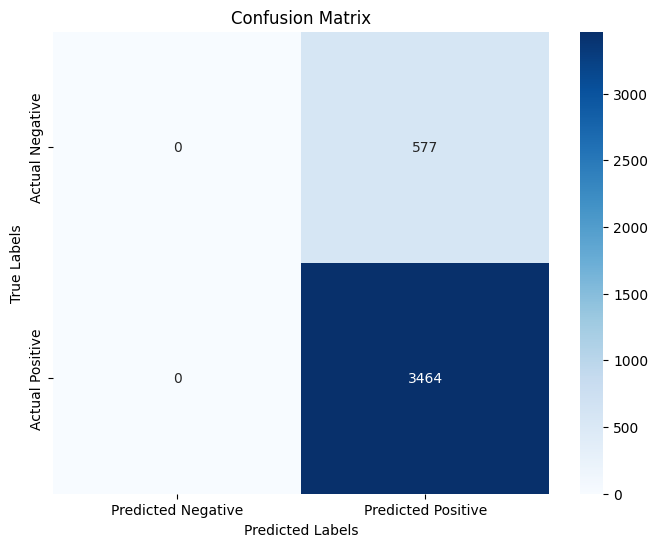

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modify the function to check if transformation is needed
if data_p2['Credit Rating'].dtype == 'object':  # Only apply if 'Credit Rating' is not already binary
    data_p2['Credit Rating'] = data_p2['Credit Rating'].apply(lambda x: 1 if x == 'Positive' else 0)

# Define feature columns and target column
X = data_p2[['Years of Education after High School', 'Requested Credit Amount',
             'Number of Dependents', 'Monthly Income', 'Monthly Expense',
             'Marital Status']]
y = data_p2['Credit Rating']

# Preprocessing for categorical features
categorical_features = ['Requested Credit Amount', 'Marital Status', 'Number of Dependents', 
                        'Monthly Income', 'Monthly Expense']
numerical_features = ['Years of Education after High School']

# Define preprocessing pipeline for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ], remainder='passthrough'  # Keeps numerical features as they are
)

# Split dataset into 50% training and 50% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Build the logistic regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Fit the model on the training data
logreg_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg_pipeline.predict(X_test)

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Part 2: Question 2

In [ ]:
# First Answer - Use predicted probabilities and adjust the models scores according to the new threshold of 15%

# Step 1: Get predicted probabilities for the positive class
y_prob = logreg_pipeline.predict_proba(X_test)[:, 1]  # Probability for the positive class (1)

# Step 2: Determine the threshold for the top 15% of predictions
# Sort the probabilities and pick the threshold that separates the top 15%
threshold = np.sort(y_prob)[-int(0.15 * len(y_prob))]

# Step 3: Apply the new threshold to classify the test set
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Step 4: Calculate evaluation metrics with the new threshold
conf_matrix_adj = confusion_matrix(y_test, y_pred_adjusted)
precision_adj = precision_score(y_test, y_pred_adjusted)
recall_adj = recall_score(y_test, y_pred_adjusted)
f1_adj = f1_score(y_test, y_pred_adjusted)

# Display results
print("New Threshold for Top 15%:", threshold)
print("Confusion Matrix (Adjusted):\n", conf_matrix_adj)
print("Precision (Adjusted):", precision_adj)
print("Recall (Adjusted):", recall_adj)
print("F1 Score (Adjusted):", f1_adj)


New Threshold for Top 15%: 0.8875251208855517
Confusion Matrix (Adjusted):
 [[ 495   82]
 [2940  524]]
Precision (Adjusted): 0.8646864686468647
Recall (Adjusted): 0.151270207852194
F1 Score (Adjusted): 0.2574938574938575


In [ ]:
# Second Answer - Calculate Probabilties of predictions, create new training and testing set according to top 15% of probabilities, re-run LogReg and review scores

# Step 1: Get predicted probabilities on the training set to adjust labels for top 15%
y_prob_train = logreg_pipeline.predict_proba(X_train)[:, 1]  # Probability for positive class (1)

# Step 2: Determine the threshold for the top 15% of probabilities in the training set
threshold_train = np.sort(y_prob_train)[-int(0.15 * len(y_prob_train))]

# Step 3: Create new adjusted labels for training based on the top 15% threshold
y_train_adjusted = (y_prob_train >= threshold_train).astype(int)

# Step 4: Retrain the logistic regression model with these adjusted labels
logreg_adjusted_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])
logreg_adjusted_pipeline.fit(X_train, y_train_adjusted)

# Step 5: Evaluate on the original test set
y_prob_test_adjusted = logreg_adjusted_pipeline.predict_proba(X_test)[:, 1]

# Apply the same threshold to classify the test set
y_pred_test_adjusted = (y_prob_test_adjusted >= threshold_train).astype(int)

# Step 6: Calculate evaluation metrics on the original test set
conf_matrix_final = confusion_matrix(y_test, y_pred_test_adjusted)
precision_final = precision_score(y_test, y_pred_test_adjusted)
recall_final = recall_score(y_test, y_pred_test_adjusted)
f1_final = f1_score(y_test, y_pred_test_adjusted)

# Display the results
print("New Threshold for Top 15%:", threshold_train)
print("Confusion Matrix (Final Model):\n", conf_matrix_final)
print("Precision (Final Model):", precision_final)
print("Recall (Final Model):", recall_final)
print("F1 Score (Final Model):", f1_final)

New Threshold for Top 15%: 0.8875251208855517
Confusion Matrix (Final Model):
 [[ 538   39]
 [3167  297]]
Precision (Final Model): 0.8839285714285714
Recall (Final Model): 0.08573903002309469
F1 Score (Final Model): 0.1563157894736842
